# Bagging and AdaBoost


In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 1 Setting

* $N \in \mathbb{N}$ : the number of observation data
* $D \in \mathbb{N}$ : the dimension of observation data
* $X = (x_0, x_1, \dots, x_{N-1})$ : the set of observation data. $x_n \in \mathbb{R}^D$
* $t = (t_0, t_1, \dots, t_{N-1})$ : the target labels. $t_n \in \{ 1, -1 \}$
* $y : \mathbb{R}^D \times \Theta \rightarrow \{1, -1\}$ : a binary classifier parametrized by $\theta \in \Theta$.

# 2 Theory 

In this notebook, we construct strong classifier from a given simple classifier, which we call a base classifier. 

## 2.1 Base classifier : decision stump

First, let us consider an extremely simple classifier called decision stump. 


### 2.1.1 Definition 

A decision stump is characterized by parameter $\theta = (d, a, s) \in \{ 0,1, \dots, D-1 \} \times \mathbb{R} \times \{ 1, -1 \} $, whose prediction is given by
$$
\begin{align}
    y(x, (d,a,s)) = 
    \begin{cases}
        s & (x^{(d)} \geq a ) \\
        -s & (x^{(d)} < a)
    \end{cases}
\end{align}
$$
where $x \in \mathbb{R}^D$ and $x^{(d)}$ stands for its $d$th component.
In essence, the decision stump $y(\cdot, (d,a,s))$ makes prediction according to whether the $d$ th coordinate of the input is smaller than $a$ or not. 

### 2.1.2 Training
In training a decision stump, we choose a parameter $\theta$ that minimizes
$$
\begin{align}
    \sum_{n=0}^{N-1} w_n I\left[ y(x_n, \theta) \neq t_n \right], 
\end{align}
$$
where $w_n$ stands for sample weight, and will be specified later depending on the algorithm we consider.

Given training data $x_0, \dots, x_{N-1}$, we only consider $2D(N-1)$ possible decision stumps because
* there are two ways of choosing the sign $s$, 
* there are $D$ possible ways of choosing the dimension $d$, and
* although there are infinitely many ways of choosing $a$, here we limit the possible values of $a$ to be the average of two adjacent (in terms of $d$ the coordinate) training data points, which result in $N-1$ choices. 

As to the final point: The limitation does not affect the values of the error function, although it affects prediction error. Also, we assume that the training data is not single class (i.e., there are $n$ and $m$ such that $t_n \neq t_m$ ).

In the later implementation, we perform this exhaustive search.

## 2.2 Bagging 

The idea of bagging, or bootstrap aggregation, is to train $M$ base classifiers using different "training data" for each classifier, where we obtain the "training data" by resampling from the original training data. 

### 2.2.1 Training 

For $m = 0,1, \dots, M-1$, 
1. randomly sample $N$ data points from $(X,T)$ with replacement, and
2. train the $m$ th classifier $y(\cdot, \theta_m)$ using the resampled data. 

### 2.2.2 Prediction 

Output the prediction for input $x$ by 
$$
\begin{align}
    y_{bag}(x) = \mathrm{sign} \left[ \sum_{m=0}^{M-1} y(x, \theta_m) \right]
\end{align}
$$

NOTE : Eq. (14.7) in the book is for regression, and for classification, we have to take sign to obtain meaningful result. We ommitted $1/M$ factor, because here we only care about sign.

## 2.3 AdaBoost

NOTE : Formally, we can use other classifiers than decision stump for AdaBoost. However, in that case, the error function to be minimized by each base classifier is not necessarily $\sum_{n=0}^{N-1} w^{(m)}_{n} I \left[ y(x_n, \theta_m) \neq t_n \right]$, and I am not sure whether it is theoretically sound or not.

### 2.3.1 Training

In AdaBoost, we train the classifier following the algorithm shown below: 

0. input : training data $(X, T)$, base classifier $y$, the number of boosting $M$. 
1. Initialize data weights $(w_0, w_1, \dots, w_{N-1})$ as $w^{(0)}_{n} = 1/N$. 
2. For $m = 0, \dots, M-1$: 
    1. Choose $\theta_m \in \Theta$ such that
    $$
    \begin{align}
        \sum_{n=0}^{N-1} w^{(m)}_{n} I \left[ y(x_n, \theta_m) \neq t_n \right]
    \end{align}
    $$
    is minimized.
    2. Evalute 
    $$
    \begin{align}
        \varepsilon_m &:= \sum_{n=0}^{N-1} w^{(m)}_{n}  I \left[ y(x_n, \theta_m) \neq t_n \right] \\     
        \alpha_m &:= \log \left(\frac{1 - \varepsilon_m}{\varepsilon_m} \right)
    \end{align}
    $$
    3. Update the data weight by 
    $$
    \begin{align}
        \tilde{w}^{(m+1)}_{n} &= w^{(m)}_{n} \exp\left\{ \alpha_m I \left[ y(x_n, \theta_m) \neq t_n \right]  \right\} \\
        w^{(m+1)}_{n} &= \frac{\tilde{w}^{(m+1)}_{n}}{ \sum_{n'=0}^{N-1} \tilde{w}^{(m+1)}_{n'} }
    \end{align}
    $$
    
NOTE :
* We normalize the weight here, which results in apprently different (but intrinsically the same) definition of $\varepsilon_m$ from (14.16) of the book.
* It is implicitly assumed that the base classifier is better than random in the sense that $\varepsilon_m < \frac{1}{2}$ for all $m$. As far as I understand, the algorithm does not work when $\varepsilon_m > \frac{1}{2}$.

### 2.3.2 Prediction 

Having obtained the classifier, the predicted label for input $x$ is given by 
$$
\begin{align}
    \textrm{sign} \left[ \sum_{m=0}^{M-1} \alpha_m y(x, \theta_m) \right]
\end{align}
$$

# 3 From math to code

Here we define three classes, namely, `DecisionStump`, `Bagging`, and `AdaBoost`. 

We let `Bagging` and `AdaBoost` classes have `fit` and `predict` methods, and the following properties
* `BaseClassifierClass` : the class from which base classifiers are generated (class, rather than instance should be given), which is assumed to implement `fit` and `predict` methods. For `AdaBoost` class, it is also assumed that the `fit` method of `BaseClassifierClass` can handle `sample_weight`.
* `num_clfs` : $M$, i.e., the number of base classifiers used.
* `clfs` :  list for storing base classifiers



## 3.1  Decision stump

We let our `DecisionStump` class to have the following properties
* `axis` : $d$, i.e., the axis used for prediction
* `sign` : $s$
* `threshold` : $a$

In fitting a decision stump, we 
* first perform the exhaustive search over $s$ and $a$ for each dimension using `fit_onedim` method (where the axis $d$ is given), and 
* then compare the result for each dimension $d$. 

In `fit_onedim`, we use the folowoing arrays, assuming that $X, T$ and $w$ are sorted according the value of the $d$th component of the input data $X$:  
* `pred` : $(N-1, N)$ array, where `pred[m,n]` = $y\left(x_n, \left(d, \frac{x_m + x_{m+1}}{2}, 1 \right) \right)$. Note that it can be generated easily by using np.tri (Although it is inefficient in terms of memory. ).
* `mistakes` : $(N-1, N)$ array, where `mistakes[m,n]` = $I \left[ y\left(x_n, \left(d, \frac{x_m + x_{m+1}}{2}, 1 \right) \right) \neq t_n\right] $
* `errs` : $(2, N-1)$ array, where 
    * `errs[0,m]` = $\sum_{n=0}^{N-1} w_n I \left[ y\left(x_n, \left(d, \frac{x_m + x_{m+1}}{2}, 1 \right) \right) \neq t_n\right] $
    * `errs[1,m]` = $\sum_{n=0}^{N-1} w_n I \left[ y\left(x_n, \left(d, \frac{x_m + x_{m+1}}{2}, -1 \right) \right) \neq t_n\right] $

In [19]:
class DecisionStump:
    
    def __init__(self, axis=None, sign=None, threshold=None):
        self.axis = axis
        self.sign = sign
        self.threshold = threshold
    
    def fit_onedim(self, X, y, sample_weight, axis):
        '''
        Performing exhaustive search on threshold and sign, where the axis to consider is given.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        y : 1D numpy array
            (len(X),) numpy array representing labels, where y[n] represents the label corresponding to n-th point in X.
            Each element should be either 1 or -1
        sample_weight : 1D numpy array
            (len(X), ) numpy array representing the sample weights.
            The elements should be non-negative.
        axis : integer
            A non-negative integer the axis to be considered.
            Must be between 0 and X.shape(1)-1
            
        Returns
        ----------
        sign : int, 1 or -1
            Integer representing the sign s for the (candidate) decision stump
        threshold : float
            Threshold a for the (candidate) decision stump
        err : float
            Training error for the (candidate) decision stump
        '''
        N = len(X)
        
        # Here we sort everything according the axis-th coordinate of X
        sort_ind = np.argsort(X[:, axis])
        sorted_label = y[sort_ind]
        sorted_input = X[sort_ind]
        sorted_sample_weight = sample_weight[sort_ind]
        
        pred = -2*np.tri(N-1, N, k=0, dtype='int') + 1 
        mistakes = (pred != sorted_label ).astype('int')
        
        # The (weighted) error is calculated for each classifier
        errs = np.zeros((2, N-1))
        errs[0] = mistakes @ sorted_sample_weight
        errs[1] = (1 - mistakes) @ sorted_sample_weight
    
        # Here, we select the best threshold and sign
        ind = np.unravel_index(np.argmin(errs, axis=None), errs.shape)
        sign = -2*ind[0] + 1
        threshold = ( sorted_input[ind[1], axis] + sorted_input[ind[1] + 1, axis] ) / 2
        err = errs[ind]
        return sign, threshold, err
        
    def fit(self, X, y, sample_weight=None):
        '''
        Performing fitting by exhaustive search on threshold, sign, and axis.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        y : 1D numpy array
            (len(X),) numpy array representing labels, where y[n] represents the label corresponding to n-th point in X.
            Each element should be either 1 or -1
        sample_weight : 1D numpy array
            (len(X), ) numpy array representing the sample weights.
            The elements should be non-negative.
            If None, the sample_weight is assumed to be uniform.
        '''
        ##################
        # YOUR CODE HERE #
        N, D = X.shape

        if sample_weight is None:
            sample_weight = np.ones(N)/N
        
        signs = np.zeros(D)
        threshs = np.zeros(D)
        errs = np.zeros(D)
        for axis in range(D):
            # COPILOT à partit de là pour cette fonction
            signs[axis], threshs[axis], errs[axis] = self.fit_onedim(X, y, sample_weight, axis)
        self.axis = np.argmin(errs)
        self.sign = signs[self.axis]
        self.threshold = threshs[self.axis]
        ##################




    def predict(self, X):
        '''
        The method predicts the labels for the given input data X.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        
        Returns
        ----------
        y : 1D numpy array
            (len(X),) numpy array representing the predicted labels, where y[n] represents the label corresponding to n-th point in X.
        '''
        return self.sign*( 2*(X[:, self.axis] >= self.threshold) - 1 )

## 3.2 Bagging 

The implementation is rather straightforward. 

The code is written in a way that it can be used for other base classifiers, assuming that the base classifier class has `fit` and `predict` method.

In [20]:
class Bagging:
    def __init__(self, BaseClassifierClass, num_clfs):
        self.BaseClassifierClass = BaseClassifierClass # base classifier class
        self.num_clfs = num_clfs
        self.clfs = [self.BaseClassifierClass() for _ in range(self.num_clfs)]

    def fit(self, X, y):
        '''
        The method performs fitting by bagging using the given base classifier.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        y : 1D numpy array
            (len(X),) numpy array representing labels, where y[n] represents the label corresponding to n-th point in X.
            Each element should be either 1 or -1
        '''
        
        ##################
        # YOUR CODE HERE #
        N = len(X)
        for m in range(self.num_clfs):

            sample_ind = np.random.randint(0,N,N)
            X_resampled = X[sample_ind]
            y_resampled = y[sample_ind]

            self.clfs[m].fit(X_resampled, y_resampled)
        ##################
        
        
    def predict(self, X):
        '''
        The method predicts the labels for the given input data X.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        y : 1D numpy array
            (len(X),) numpy array representing the predicted labels, where y[n] represents the label corresponding to n-th point in X.
        '''
        base_pred = np.zeros((self.num_clfs, len(X)))
        for m in range(self.num_clfs):
            base_pred[m] = self.clfs[m].predict(X)
        return np.sign(  np.sum(base_pred, axis = 0 ) )

## 3.3 AdaBoost

Just like the `Bagging` class, the code is written in a way that it can be used for other base classifiers, asuming that the base classifier class has 
* `fit` method which takes input data, label, and sample weight, and 
* `predict` method.

In [21]:
class AdaBoost:
    def __init__(self, BaseClassifierClass, num_clfs):
        self.BaseClassifierClass = BaseClassifierClass # base classifier class
        self.num_clfs = num_clfs
        self.alpha = np.zeros(self.num_clfs)
        self.clfs = [self.BaseClassifierClass() for _ in range(self.num_clfs)]
        
    def fit(self, X, y):
        '''
        The method performs fitting by AdaBoost using the given base classifier.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        y : 1D numpy array
            (len(X),) numpy array representing labels, where y[n] represents the label corresponding to n-th point in X.
            Each element should be either 1 or -1
        '''
        
        ##################
        # YOUR CODE HERE #
        N = len(X)
        w = np.ones(N)/N
        for m in range(self.num_clfs):
            self.clfs[m].fit(X, y, sample_weight = w)
            mistakes = (self.clfs[m].predict(X) != y)
            
            e_p = np.sum(w * mistakes)
            self.alpha[m] = np.log(1.0/e_p - 1)

            w = w * np.exp(self.alpha[m] * mistakes)
            w = w / np.sum(w)
        ##################
        
        
    def predict(self, X):
        '''
        The method predicts the labels for the given input data X.
        
        Parameters
        ----------
        X : 2D numpy array
            2D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        y : 1D numpy array
            (len(X),) numpy array representing the predicted labels, where y[n] represents the label corresponding to n-th point in X.
        '''
        base_pred = np.zeros((self.num_clfs, len(X)))
        for m in range(self.num_clfs):
            base_pred[m] = self.clfs[m].predict(X)
        return np.sign( base_pred.T @ self.alpha )

# 4 Experiment

## 4.1 Data and preparation

In [22]:
def get_meshgrid(x, y, nx, ny, margin=0.1):
    x_min, x_max = (1 + margin) * x.min() - margin * x.max(), (1 + margin) * x.max() - margin * x.min()
    y_min, y_max = (1 + margin) * y.min() - margin * y.max(), (1 + margin) * y.max() - margin * y.min()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    return xx, yy


def plot_result(ax, clf, xx, yy, X, y):
    pred = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, pred, alpha=0.7)
    ax.scatter(X[:,0], X[:,1], c=y, edgecolor='k')


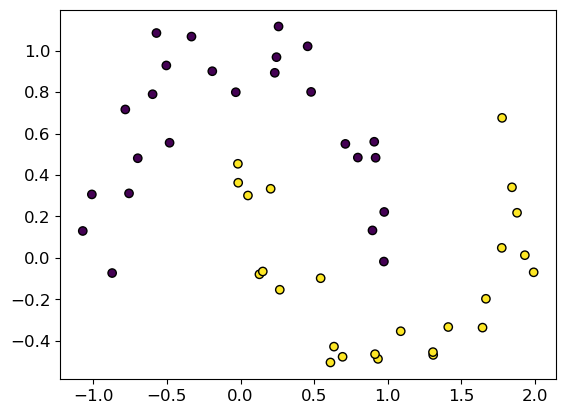

In [34]:
from sklearn import datasets

X, y = datasets.make_moons(n_samples = 50, noise = 0.1, random_state=1)
y = 2*y-1
plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k')

xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=100, ny=100, margin=0.1)

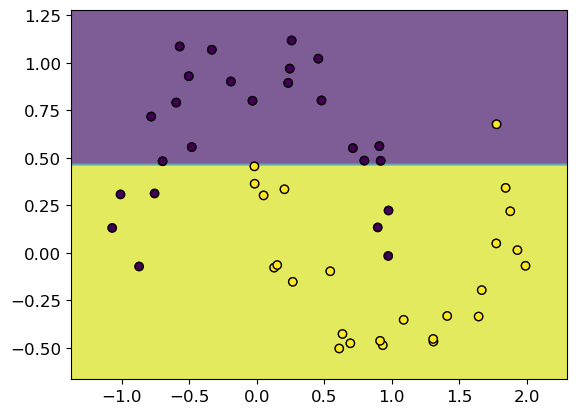

In [26]:
from sklearn import datasets

X, y = datasets.make_moons(n_samples = 50, noise = 0.1, random_state=1)
y = 2*y-1
plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k')

xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=100, ny=100, margin=0.1)

clf = DecisionStump()
clf.fit(X, y)
plot_result(plt.gca(), clf, xx, yy, X, y)
plt.show()

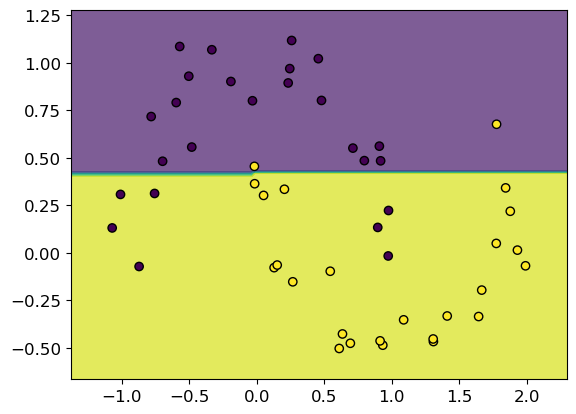

In [135]:
clf = Bagging(DecisionStump,20)
clf.fit(X, y)
plot_result(plt.gca(), clf, xx, yy, X, y)
plt.show()

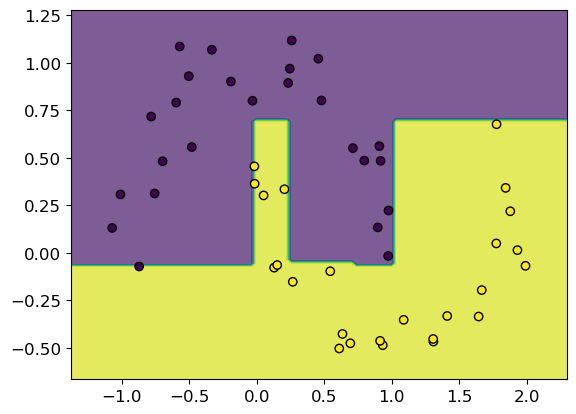

In [136]:
clf = AdaBoost(DecisionStump, 20)
clf.fit(X, y)
plot_result(plt.gca(), clf, xx, yy, X, y)
plt.show()